## Image Matching

Image matching is an important concept in computer vision and object recognition. The images of the same subject can be acquired from different angles, lighting and scales. Therefore, it is best to find features that are descriptive and invariant to the aforementioned variations in order to categorize the images correctly.

SIFT helps locate the local features in an image, commonly known as the ‘keypoints‘ of the image. These keypoints are scale & rotation invariant that can be used for various computer vision applications, like image matching, object detection, scene detection, etc.

We can also use the keypoints generated using SIFT as features for the image during model training. The major advantage of SIFT features, over edge features or hog features, is that they are not affected by the size or orientation of the image.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
from natsort import natsorted

In [3]:
!pip install opencv-python==4.4.0.40
!pip install opencv-contrib-python==4.4.0.40

In [4]:
cv2.__version__

'4.4.0'

### Now, for each image, we are going to generate the SIFT features. First, we have to construct a SIFT object and then use the function detectAndCompute to get the keypoints. It will return two values – the keypoints and the descriptors.

Next, match the features of each possible pair of images using match() from the BFmatcher (brute force match) module.



In [5]:
file1 = open(r"/content/drive/MyDrive/ML_Class_Project/scores_sift.txt", "w")
path1 = r'/content/drive/MyDrive/ML_Class_Project/Data'

sift = cv2.SIFT_create()
bf = cv2.BFMatcher()
stor = {}
for images in natsorted(os.listdir(path1)):
    str1 = str(images)
    img1 = os.path.join(path1, images)
    #print(img1)
    img3 = cv2.imread(img1)
    kp1, des1 = sift.detectAndCompute(img3,None)
    stor[img1] = (kp1, des1)

for images in natsorted(os.listdir(path1)):
    str1 = str(images)
    img1 = os.path.join(path1, images)
    #print(img1)
    #img1 = cv2.imread(img1)
    (kp1, des1) = stor[img1]

    if len(kp1)>0:
       for image in natsorted(os.listdir(path1)):
           img2 = os.path.join(path1, image)
        #print(img2)
           str2 = str(image)
           if (img1 != img2): # queryImage
               #img2 = cv2.imread(img2) # trainImage
               (kp2, des2) = stor[img2]
            # Initiate SIFT detector
            #sift = cv2.SIFT()            
            # find the keypoints and descriptors with SIFT
            # BFMatcher with default params
               if len(kp1) ==0 or len(kp2) == 0 or len(kp1) == 1 or len(kp2) == 1:
                    continue
               matches1 = bf.knnMatch(des1,des2, k=2)
               matches2 = bf.knnMatch(des2,des1, k=2)
               dis = bf.match(des1,des2)
            #----------------------------------------------
               number_keypoints = 0
               if len(kp1) >= len(kp2):
                   number_keypoints = len(kp1)
               else:
                   number_keypoints = len(kp2)
               good1 = []
               good2 = []
               for m,n in matches1:
                   if m.distance < 0.7*n.distance:
                      good1.append([m])
               for m,n in matches2:
                   if m.distance < 0.7*n.distance:
                      good2.append([m])
            #print("Keypoints 1ST Image: " + str(len(kp1)))
            #print("Keypoints 2ND Image: " + str(len(kp2)))
            #print("GOOD Matches:", len(good))
               score1 = len(good1) / number_keypoints
               score2 = len(good2) / number_keypoints
               score = min(score1,score2)
               
            #print("How good it's the match: ", score) #* 100, "%")
               file1.write( str1 + " " + str2 + " " + str(score)+"\n")
               #print(str1 + " " + str2 + " " + str(score)) # replace with 'cos' if using cosine similarity

file1.close()

In [122]:
df = open("/content/drive/MyDrive/ML_Class_Project/scores_sift.txt", "r")
imp = []
gen = []
lines = df.readlines()
for l in lines:
  subline = l.strip()
  pictures = subline.split(' ')
  pic1 = pictures[0][0:2]
  pic2 = pictures[1][0:2]
  val = float(pictures[2])            
  if (pic1 == pic2):           
    gen.append(val)
  if  (pic1!=pic2):               
    imp.append(val)  


In [123]:
frr = []
far = []
thrshld = np.arange(0,1,0.001)
gen_length = len(gen)
imp_length = len(imp)
for e in thrshld :
  frr_cnt = 0
  far_cnt = 0
  for x in gen : 
    if x< e : frr_cnt = frr_cnt+1
  for y in imp :
    if y>= e : far_cnt = far_cnt+1
  frr.append(frr_cnt/ gen_length)    
  far.append(far_cnt/ imp_length)
   

Text(0.5, 1.0, 'ROC using SIFT')

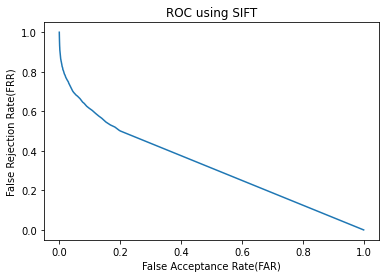

In [124]:
plt.plot(far,frr)
plt.xlabel('False Acceptance Rate(FAR)')
plt.ylabel('False Rejection Rate(FRR)')
plt.title('ROC using SIFT')


In [125]:
eer_val = 1
eer_thrshld = 0
max=5
for x in thrshld:
  if abs(far[int (1000*x)]-frr[int (1000*x)]) <= eer_val :
    max = abs(far[int (1000*x)]+frr[int(1000*x)])/2
    eer_val = abs(far[int (1000*x)]-frr[int (1000*x)])
    eer_thrshld = x
print("EER_Value == "+ str (max)+ " EER_Threshold = = "+ str (eer_thrshld)) 

EER_Value == 0.35049642409134035 EER_Threshold = = 0.001


In [127]:
accuracy=[]
for x in thrshld:
  accuracy.append(100-50*((frr[int(1000*x)]+ far[int(1000*x)])))
  print("Accuracy = "+ str(100-50*((frr[int(1000*x)]+ far[int(1000*x)])))+ " Threshold = "+ str (x))

Accuracy = 50.0 Threshold = 0.0
Accuracy = 64.95035759086596 Threshold = 0.001
Accuracy = 64.96716399526102 Threshold = 0.002
Accuracy = 64.84885614994414 Threshold = 0.003
Accuracy = 65.05368779420144 Threshold = 0.004
Accuracy = 65.05264538435384 Threshold = 0.005
Accuracy = 64.77681365928834 Threshold = 0.006
Accuracy = 64.71019127804729 Threshold = 0.007
Accuracy = 64.5771434491404 Threshold = 0.008
Accuracy = 64.3632551148322 Threshold = 0.009000000000000001
Accuracy = 64.30888224922799 Threshold = 0.01
Accuracy = 64.2162668177437 Threshold = 0.011
Accuracy = 63.900125451487135 Threshold = 0.012
Accuracy = 63.84089636972604 Threshold = 0.013000000000000001
Accuracy = 63.38816971521998 Threshold = 0.014
Accuracy = 63.17218936165089 Threshold = 0.015
Accuracy = 63.144156143564466 Threshold = 0.016
Accuracy = 62.99136376022327 Threshold = 0.017
Accuracy = 62.863468202342084 Threshold = 0.018000000000000002
Accuracy = 62.67609346869492 Threshold = 0.019
Accuracy = 62.356540017351186 T

In [134]:
max_accuracy = np.max(accuracy) 
print('Accuracy using SIFT is '+str(max_accuracy))

Accuracy using SIFT is 65.05368779420144


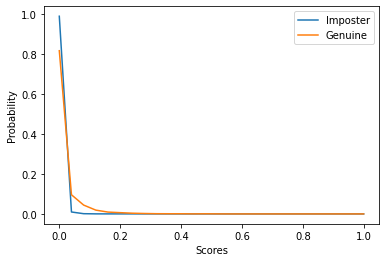

In [76]:
impcnt = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
impprob = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
gencnt = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
genprob = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in imp :
  one = int(i/0.04)
  impcnt[one]+=1
for j in gen :
  two = int(j/0.04)
  gencnt[two]+=1
impprob[:] = [x/ imp_length for x in impcnt]
genprob[:] = [x/ gen_length for x in gencnt]
pts = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in range(26) :
  pts[i] = i/25
plt.plot(pts,impprob, label = 'Imposter')
plt.plot(pts,genprob, label = 'Genuine')
plt.xlabel('Scores')
plt.ylabel('Probability')
plt.legend()
plt.show()

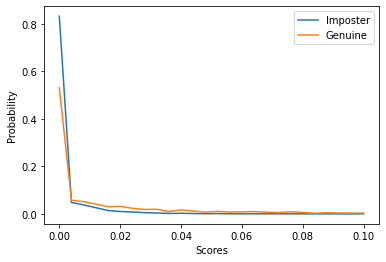

In [77]:
impcnt = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
impprob = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
gencnt = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
genprob = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in imp :
  if(i<=0.1):
   one = int(i/0.004)
   impcnt[one]+=1
for j in gen :
  if(j<=0.1):
   two = int(j/0.004)
   gencnt[two]+=1
impprob[:] = [x/ imp_length for x in impcnt]
genprob[:] = [x/ gen_length for x in gencnt]
ve = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
for i in np.arange(0.0,2.6,0.1) :
  ve[int(i*10)] = i/25
plt.plot(ve,impprob, label = 'Imposter')
plt.plot(ve,genprob, label = 'Genuine')
plt.xlabel('Scores')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [78]:
df = open("/content/drive/MyDrive/ML_Class_Project/scores_sift.txt", "r")
val_dictionary = {}
index_dictionary = {}
for l in df:
  w = l.split(' ')
  val_dictionary[w[0]] = 0
  index_dictionary[w[0]] = '0'

In [79]:
df = open("/content/drive/MyDrive/ML_Class_Project/scores_sift.txt", "r")
for l in df:
  w = l.split(' ')
  scr = float((w[2].split('\n'))[0])
  pone = int((w[0].split('_'))[0])
  ptwo = int((w[1].split('_'))[0])
  if (scr > val_dictionary[w[0]]  ) or (scr >= val_dictionary[w[0]] and  pone == ptwo )   :
    val_dictionary[w[0]] = scr
    index_dictionary[w[0]] = w[1]
df.close()

In [81]:
total_sift = 0
crct_sift = 0
for key in val_dictionary.keys():
  total_sift +=1
  image1 = key.split("_")[0]
  image2 = index_dictionary[key].split("_")[0]
  if image1 == image2 :
    crct_sift += 1
CRR_sift = crct_sift/total_sift
print('CRR using SIFT is '+str(CRR_sift))    

CRR using SIFT is 0.7412844036697248


In [ ]:
file1 = open(r"/content/drive/MyDrive/ML_Class_Project/scores_orb.txt", "w")
path1 = r'/content/drive/MyDrive/ML_Class_Project/Data'

orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = False)
stor = {}
for images in natsorted(os.listdir(path1)):
    str1 = str(images)
    img1 = os.path.join(path1, images)
    #print(img1)
    img3 = cv2.imread(img1)
    kp1, des1 = orb.detectAndCompute(img3,None)
    stor[img1] = (kp1, des1)

for images in natsorted(os.listdir(path1)):
    str1 = str(images)
    img1 = os.path.join(path1, images)
    #print(img1)
    #img1 = cv2.imread(img1)
    (kp1, des1) = stor[img1]

    if len(kp1)>0:
       for image in natsorted(os.listdir(path1)):
           img2 = os.path.join(path1, image)
        #print(img2)
           str2 = str(image)
           if (img1 != img2): # queryImage
               #img2 = cv2.imread(img2) # trainImage
               (kp2, des2) = stor[img2]
            # Initiate SIFT detector
            #sift = cv2.SIFT()            
            # find the keypoints and descriptors with SIFT
            # BFMatcher with default params
               if len(kp1) ==0 or len(kp2) == 0 or len(kp1) == 1 or len(kp2) == 1:
                    continue
               matches1 = bf.knnMatch(des1,des2, k=2)
               matches2 = bf.knnMatch(des2,des1, k=2)
               dis = bf.match(des1,des2)
            #----------------------------------------------
               number_keypoints = 0
               if len(kp1) >= len(kp2):
                   number_keypoints = len(kp1)
               else:
                   number_keypoints = len(kp2)
               good1 = []
               good2 = []
               for m,n in matches1:
                   if m.distance < 0.7*n.distance:
                      good1.append([m])
               for m,n in matches2:
                   if m.distance < 0.7*n.distance:
                      good2.append([m])
            #print("Keypoints 1ST Image: " + str(len(kp1)))
            #print("Keypoints 2ND Image: " + str(len(kp2)))
            #print("GOOD Matches:", len(good))
               score1 = len(good1) / number_keypoints
               score2 = len(good2) / number_keypoints
               score = min(score1,score2)
               
            #print("How good it's the match: ", score) #* 100, "%")
               file1.write( str1 + " " + str2 + " " + str(score)+"\n")
               print(str1 + " " + str2 + " " + str(score)) # replace with 'cos' if using cosine similarity

file1.close()

In [135]:
df = open("/content/drive/MyDrive/ML_Class_Project/scores_orb.txt", "r")
imp = []
gen = []
lines = df.readlines()
for l in lines:
  subline = l.strip()
  pictures = subline.split(' ')
  pic1 = pictures[0][0:2]
  pic2 = pictures[1][0:2]
  val = float(pictures[2])            
  if (pic1 == pic2):           
    gen.append(val)
  if  (pic1!=pic2):               
    imp.append(val)  


In [136]:
frr = []
far = []
thrshld = np.arange(0,1,0.001)
gen_length = len(gen)
imp_length = len(imp)
for e in thrshld :
  frr_cnt = 0
  far_cnt = 0
  for x in gen : 
    if x< e : frr_cnt = frr_cnt+1
  for y in imp :
    if y>= e : far_cnt = far_cnt+1
  frr.append(frr_cnt/ gen_length)    
  far.append(far_cnt/ imp_length)

Text(0.5, 1.0, 'ROC using ORB')

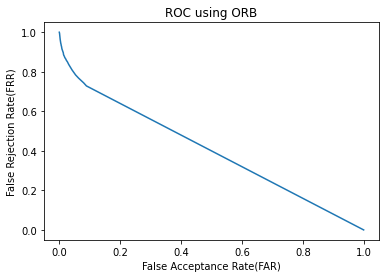

In [137]:
plt.plot(far,frr)
plt.xlabel('False Acceptance Rate(FAR)')
plt.ylabel('False Rejection Rate(FRR)')
plt.title('ROC using ORB')

In [138]:
eer_val = 1
eer_thrshld = 0
max=5
for x in thrshld:
  if abs(far[int (1000*x)]-frr[int (1000*x)]) <= eer_val :
    max = abs(far[int (1000*x)]+frr[int(1000*x)])/2
    eer_val = abs(far[int (1000*x)]-frr[int (1000*x)])
    eer_thrshld = x
print("EER_Value == "+ str (max)+ " EER_Threshold = = "+ str (eer_thrshld)) 

EER_Value == 0.4088011320728077 EER_Threshold = = 0.002


In [139]:
accuracy=[]
for x in thrshld:
  accuracy.append(100-50*((frr[int(1000*x)]+ far[int(1000*x)])))
  print("Accuracy = "+ str(100-50*((frr[int(1000*x)]+ far[int(1000*x)])))+ " Threshold = "+ str (x))

Accuracy = 50.0 Threshold = 0.0
Accuracy = 59.11988679271923 Threshold = 0.001
Accuracy = 59.11988679271923 Threshold = 0.002
Accuracy = 58.80242243473896 Threshold = 0.003
Accuracy = 58.43981819813232 Threshold = 0.004
Accuracy = 58.12274315166486 Threshold = 0.005
Accuracy = 57.44015156526422 Threshold = 0.006
Accuracy = 56.944684488226 Threshold = 0.007
Accuracy = 56.57133614010349 Threshold = 0.008
Accuracy = 56.16815273011465 Threshold = 0.009000000000000001
Accuracy = 55.94986494194906 Threshold = 0.01
Accuracy = 55.64712529492341 Threshold = 0.011
Accuracy = 55.50278200614393 Threshold = 0.012
Accuracy = 55.24219384459073 Threshold = 0.013000000000000001
Accuracy = 55.1169187171951 Threshold = 0.014
Accuracy = 54.917519690604024 Threshold = 0.015
Accuracy = 54.5467895415335 Threshold = 0.016
Accuracy = 54.35067668392663 Threshold = 0.017
Accuracy = 54.230515907058255 Threshold = 0.018000000000000002
Accuracy = 54.13792306969527 Threshold = 0.019
Accuracy = 54.027151347067466 Thr

In [140]:
max_accuracy = np.max(accuracy) 
print('Accuracy using ORB is '+str(max_accuracy))

Accuracy using ORB is 59.11988679271923


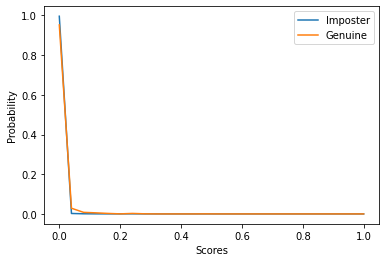

In [87]:
impcnt = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
impprob = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
gencnt = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
genprob = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in imp :
  one = int(i/0.04)
  impcnt[one]+=1
for j in gen :
  two = int(j/0.04)
  gencnt[two]+=1
impprob[:] = [x/ imp_length for x in impcnt]
genprob[:] = [x/ gen_length for x in gencnt]
pts = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in range(26) :
  pts[i] = i/25
plt.plot(pts,impprob, label = 'Imposter')
plt.plot(pts,genprob, label = 'Genuine')
plt.xlabel('Scores')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [88]:
df = open("/content/drive/MyDrive/ML_Class_Project/scores_orb.txt", "r")
val_dictionary = {}
index_dictionary = {}
for l in df:
  w = l.split(' ')
  val_dictionary[w[0]] = 0
  index_dictionary[w[0]] = '0'

In [89]:
df = open("/content/drive/MyDrive/ML_Class_Project/scores_orb.txt", "r")
for l in df:
  w = l.split(' ')
  scr = float((w[2].split('\n'))[0])
  pone = int((w[0].split('_'))[0])
  ptwo = int((w[1].split('_'))[0])
  if (scr > val_dictionary[w[0]]  ) or (scr >= val_dictionary[w[0]] and  pone == ptwo )   :
    val_dictionary[w[0]] = scr
    index_dictionary[w[0]] = w[1]
df.close()

In [90]:
total_orb = 0
crct_orb = 0
for key in val_dictionary.keys():
  total_orb +=1
  image1 = key.split("_")[0]
  image2 = index_dictionary[key].split("_")[0]
  if image1 == image2 :
    crct_orb += 1
CRR_orb = crct_orb/total_orb
print('CRR using ORB is '+str(CRR_orb))   

CRR using ORB is 0.5319148936170213


In [1]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [6]:
cv2.__version__

'3.4.2'

In [ ]:
file1 = open(r"/content/drive/MyDrive/ML_Class_Project/scores_surf.txt", "w")
path1 = r'/content/drive/MyDrive/ML_Class_Project/Data'

surf = cv2.xfeatures2d.SURF_create()
#sift=cv2.SIFT_create()
bf = cv2.BFMatcher()
stor = {}
for images in natsorted(os.listdir(path1)):
    str1 = str(images)
    img1 = os.path.join(path1, images)
    #print(img1)
    img3 = cv2.imread(img1)
    kp1, des1 = surf.detectAndCompute(img3,None)
    stor[img1] = (kp1, des1)

for images in natsorted(os.listdir(path1)):
    str1 = str(images)
    img1 = os.path.join(path1, images)
    #print(img1)
    #img1 = cv2.imread(img1)
    (kp1, des1) = stor[img1]

    if len(kp1)>0:
       for image in natsorted(os.listdir(path1)):
           img2 = os.path.join(path1, image)
        #print(img2)
           str2 = str(image)
           if (img1 != img2): # queryImage
               #img2 = cv2.imread(img2) # trainImage
               (kp2, des2) = stor[img2]
            # Initiate SIFT detector
            #sift = cv2.SIFT()            
            # find the keypoints and descriptors with SIFT
            # BFMatcher with default params
               if len(kp1) ==0 or len(kp2) == 0 or len(kp1) == 1 or len(kp2) == 1:
                    continue
               matches1 = bf.knnMatch(des1,des2, k=2)
               matches2 = bf.knnMatch(des2,des1, k=2)
               dis = bf.match(des1,des2)
            #----------------------------------------------
               number_keypoints = 0
               if len(kp1) >= len(kp2):
                   number_keypoints = len(kp1)
               else:
                   number_keypoints = len(kp2)
               good1 = []
               good2 = []
               for m,n in matches1:
                   if m.distance < 0.7*n.distance:
                      good1.append([m])
               for m,n in matches2:
                   if m.distance < 0.7*n.distance:
                      good2.append([m])
            #print("Keypoints 1ST Image: " + str(len(kp1)))
            #print("Keypoints 2ND Image: " + str(len(kp2)))
            #print("GOOD Matches:", len(good))
               score1 = len(good1) / number_keypoints
               score2 = len(good2) / number_keypoints
               score = min(score1,score2)
               
            #print("How good it's the match: ", score) #* 100, "%")
               file1.write( str1 + " " + str2 + " " + str(score)+"\n")
               print(str1 + " " + str2 + " " + str(score)) # replace with 'cos' if using cosine similarity

file1.close()

In [141]:
df = open("/content/drive/MyDrive/ML_Class_Project/scores_surf.txt", "r")
imp = []
gen = []
lines = df.readlines()
for l in lines:
  subline = l.strip()
  pictures = subline.split(' ')
  pic1 = pictures[0][0:2]
  pic2 = pictures[1][0:2]
  val = float(pictures[2])            
  if (pic1 == pic2):           
    gen.append(val)
  if  (pic1!=pic2):               
    imp.append(val)  


In [142]:
frr = []
far = []
thrshld = np.arange(0,1,0.001)
gen_length = len(gen)
imp_length = len(imp)
for e in thrshld :
  frr_cnt = 0
  far_cnt = 0
  for x in gen : 
    if x< e : frr_cnt = frr_cnt+1
  for y in imp :
    if y>= e : far_cnt = far_cnt+1
  frr.append(frr_cnt/ gen_length)    
  far.append(far_cnt/ imp_length)


Text(0.5, 1.0, 'ROC using SURF')

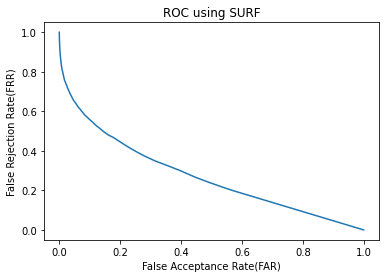

In [143]:
plt.plot(far,frr)
plt.xlabel('False Acceptance Rate(FAR)')
plt.ylabel('False Rejection Rate(FRR)')
plt.title('ROC using SURF')

In [144]:
eer_val = 1
eer_thrshld = 0
max=5
for x in thrshld:
  if abs(far[int (1000*x)]-frr[int (1000*x)]) <= eer_val :
    max = abs(far[int (1000*x)]+frr[int(1000*x)])/2
    eer_val = abs(far[int (1000*x)]-frr[int (1000*x)])
    eer_thrshld = x
print("EER_Value == "+ str (max)+ " EER_Threshold = = "+ str (eer_thrshld)) 

EER_Value == 0.33907176214920554 EER_Threshold = = 0.006


In [145]:
accuracy=[]
for x in thrshld:
  accuracy.append(100-50*((frr[int(1000*x)]+ far[int(1000*x)])))
  print("Accuracy = "+ str(100-50*((frr[int(1000*x)]+ far[int(1000*x)])))+ " Threshold = "+ str (x))

Accuracy = 50.0 Threshold = 0.0
Accuracy = 61.45288321952116 Threshold = 0.001
Accuracy = 62.178964756529496 Threshold = 0.002
Accuracy = 63.43735622929335 Threshold = 0.003
Accuracy = 64.3180366252211 Threshold = 0.004
Accuracy = 65.15696537389633 Threshold = 0.005
Accuracy = 66.09282378507945 Threshold = 0.006
Accuracy = 66.79844385572052 Threshold = 0.007
Accuracy = 67.30573045782367 Threshold = 0.008
Accuracy = 67.58326221339155 Threshold = 0.009000000000000001
Accuracy = 67.71566232801727 Threshold = 0.01
Accuracy = 67.74459866262663 Threshold = 0.011
Accuracy = 67.736208043939 Threshold = 0.012
Accuracy = 67.92652083908388 Threshold = 0.013000000000000001
Accuracy = 67.83729245440725 Threshold = 0.014
Accuracy = 67.64315200802588 Threshold = 0.015
Accuracy = 67.54521708330822 Threshold = 0.016
Accuracy = 67.24910555056331 Threshold = 0.017
Accuracy = 67.10186274896395 Threshold = 0.018000000000000002
Accuracy = 66.88693026528303 Threshold = 0.019
Accuracy = 66.74367023832664 Thre

In [146]:
max_accuracy = np.max(accuracy) 
print('Accuracy using SURF is '+str(max_accuracy))

Accuracy using SURF is 67.92652083908388


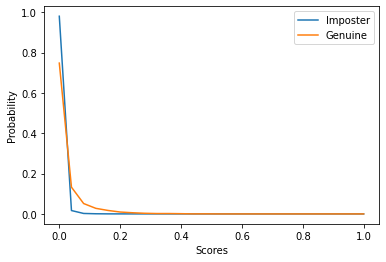

In [108]:
impcnt = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
impprob = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
gencnt = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
genprob = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in imp :
  one = int(i/0.04)
  impcnt[one]+=1
for j in gen :
  two = int(j/0.04)
  gencnt[two]+=1
impprob[:] = [x/ imp_length for x in impcnt]
genprob[:] = [x/ gen_length for x in gencnt]
pts = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in range(26) :
  pts[i] = i/25
plt.plot(pts,impprob, label = 'Imposter')
plt.plot(pts,genprob, label = 'Genuine')
plt.xlabel('Scores')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [109]:
df = open("/content/drive/MyDrive/ML_Class_Project/scores_surf.txt", "r")
val_dictionary = {}
index_dictionary = {}
for l in df:
  w = l.split(' ')
  val_dictionary[w[0]] = 0
  index_dictionary[w[0]] = '0'

In [110]:
df = open("/content/drive/MyDrive/ML_Class_Project/scores_surf.txt", "r")
for l in df:
  w = l.split(' ')
  scr = float((w[2].split('\n'))[0])
  pone = int((w[0].split('_'))[0])
  ptwo = int((w[1].split('_'))[0])
  if (scr > val_dictionary[w[0]]  ) or (scr >= val_dictionary[w[0]] and  pone == ptwo )   :
    val_dictionary[w[0]] = scr
    index_dictionary[w[0]] = w[1]
df.close()


In [111]:
total_surf = 0
crct_surf = 0
for key in val_dictionary.keys():
  total_surf +=1
  image1 = key.split("_")[0]
  image2 = index_dictionary[key].split("_")[0]
  if image1 == image2 :
    crct_surf += 1
CRR_surf = crct_surf/total_surf
print('CRR using SURF is '+str(CRR_surf))   

CRR using SURF is 0.8079584775086506


In [ ]:
file1 = open(r"/content/drive/MyDrive/ML_Class_Project/scores_brief.txt", "w")
path1 = r'/content/drive/MyDrive/ML_Class_Project/Data'

star_trek = cv2.xfeatures2d.StarDetector_create()
# Initiate BRIEF extractor
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
stor = {}
for images in natsorted(os.listdir(path1)):
    str1 = str(images)
    img1 = os.path.join(path1, images)
    #print(img1)
    img3 = cv2.imread(img1)
    kp1 = star_trek.detect(img3,None)
    kp1, des1 = brief.compute(img3, kp1)

    stor[img1] = (kp1, des1)

for images in natsorted(os.listdir(path1)):
    str1 = str(images)
    img1 = os.path.join(path1, images)
    #print(img1)
    #img1 = cv2.imread(img1)
    (kp1, des1) = stor[img1]

    if len(kp1)>0:
       for image in natsorted(os.listdir(path1)):
           img2 = os.path.join(path1, image)
        #print(img2)
           str2 = str(image)
           if (img1 != img2): # queryImage
               #img2 = cv2.imread(img2) # trainImage
               (kp2, des2) = stor[img2]
            # Initiate SIFT detector
            #sift = cv2.SIFT()            
            # find the keypoints and descriptors with SIFT
            # BFMatcher with default params
               if len(kp1) ==0 or len(kp2) == 0 or len(kp1) == 1 or len(kp2) == 1:
                    continue
               matches1 = bf.knnMatch(des1,des2, k=2)
               matches2 = bf.knnMatch(des2,des1, k=2)
               dis = bf.match(des1,des2)
            #----------------------------------------------
               number_keypoints = 0
               if len(kp1) >= len(kp2):
                   number_keypoints = len(kp1)
               else:
                   number_keypoints = len(kp2)
               good1 = []
               good2 = []
               for m,n in matches1:
                   if m.distance < 0.7*n.distance:
                      good1.append([m])
               for m,n in matches2:
                   if m.distance < 0.7*n.distance:
                      good2.append([m])
            #print("Keypoints 1ST Image: " + str(len(kp1)))
            #print("Keypoints 2ND Image: " + str(len(kp2)))
            #print("GOOD Matches:", len(good))
               score1 = len(good1) / number_keypoints
               score2 = len(good2) / number_keypoints
               score = min(score1,score2)
               
            #print("How good it's the match: ", score) #* 100, "%")
               file1.write( str1 + " " + str2 + " " + str(score)+"\n")
               print(str1 + " " + str2 + " " + str(score)) # replace with 'cos' if using cosine similarity

file1.close()

In [147]:
df = open("/content/drive/MyDrive/ML_Class_Project/scores_brief.txt", "r")
imp = []
gen = []
lines = df.readlines()
for l in lines:
  subline = l.strip()
  pictures = subline.split(' ')
  pic1 = pictures[0][0:2]
  pic2 = pictures[1][0:2]
  val = float(pictures[2])            
  if (pic1 == pic2):           
    gen.append(val)
  if  (pic1!=pic2):               
    imp.append(val)  

In [148]:
frr = []
far = []
thrshld = np.arange(0,1,0.001)
gen_length = len(gen)
imp_length = len(imp)
for e in thrshld :
  frr_cnt = 0
  far_cnt = 0
  for x in gen : 
    if x< e : frr_cnt = frr_cnt+1
  for y in imp :
    if y>= e : far_cnt = far_cnt+1
  frr.append(frr_cnt/ gen_length)    
  far.append(far_cnt/ imp_length)


Text(0.5, 1.0, 'ROC using BRIEF')

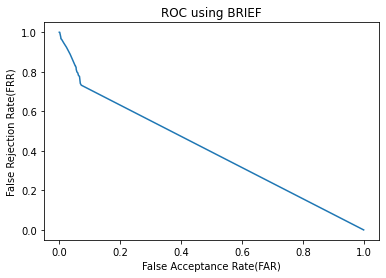

In [149]:
plt.plot(far,frr)
plt.xlabel('False Acceptance Rate(FAR)')
plt.ylabel('False Rejection Rate(FRR)')
plt.title('ROC using BRIEF')

In [150]:
eer_val = 1
eer_thrshld = 0
max=5
for x in thrshld:
  if abs(far[int (1000*x)]-frr[int (1000*x)]) <= eer_val :
    max = abs(far[int (1000*x)]+frr[int(1000*x)])/2
    eer_val = abs(far[int (1000*x)]-frr[int (1000*x)])
    eer_thrshld = x
print("EER_Value == "+ str (max)+ " EER_Threshold = = "+ str (eer_thrshld)) 

EER_Value == 0.4022306918433679 EER_Threshold = = 0.066


In [151]:
accuracy=[]
for x in thrshld:
  accuracy.append(100-50*((frr[int(1000*x)]+ far[int(1000*x)])))
  print("Accuracy = "+ str(100-50*((frr[int(1000*x)]+ far[int(1000*x)])))+ " Threshold = "+ str (x))

Accuracy = 50.0 Threshold = 0.0
Accuracy = 59.776930815663206 Threshold = 0.001
Accuracy = 59.776930815663206 Threshold = 0.002
Accuracy = 59.776930815663206 Threshold = 0.003
Accuracy = 59.776930815663206 Threshold = 0.004
Accuracy = 59.776930815663206 Threshold = 0.005
Accuracy = 59.776930815663206 Threshold = 0.006
Accuracy = 59.776930815663206 Threshold = 0.007
Accuracy = 59.776930815663206 Threshold = 0.008
Accuracy = 59.776930815663206 Threshold = 0.009000000000000001
Accuracy = 59.776930815663206 Threshold = 0.01
Accuracy = 59.776930815663206 Threshold = 0.011
Accuracy = 59.776930815663206 Threshold = 0.012
Accuracy = 59.776930815663206 Threshold = 0.013000000000000001
Accuracy = 59.776930815663206 Threshold = 0.014
Accuracy = 59.776930815663206 Threshold = 0.015
Accuracy = 59.776930815663206 Threshold = 0.016
Accuracy = 59.776930815663206 Threshold = 0.017
Accuracy = 59.776930815663206 Threshold = 0.018000000000000002
Accuracy = 59.776930815663206 Threshold = 0.019
Accuracy = 5

In [152]:
max_accuracy = np.max(accuracy) 
print('Accuracy using BRIEF is '+str(max_accuracy))

Accuracy using BRIEF is 59.776930815663206


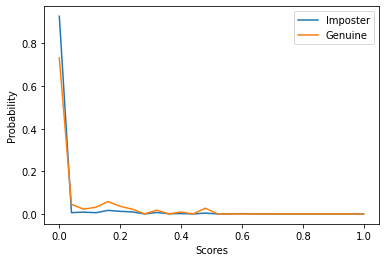

In [117]:
impcnt = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
impprob = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
gencnt = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
genprob = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in imp :
  one = int(i/0.04)
  impcnt[one]+=1
for j in gen :
  two = int(j/0.04)
  gencnt[two]+=1
impprob[:] = [x/ imp_length for x in impcnt]
genprob[:] = [x/ gen_length for x in gencnt]
pts = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in range(26) :
  pts[i] = i/25
plt.plot(pts,impprob, label = 'Imposter')
plt.plot(pts,genprob, label = 'Genuine')
plt.xlabel('Scores')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [118]:
df = open("/content/drive/MyDrive/ML_Class_Project/scores_brief.txt", "r")
val_dictionary = {}
index_dictionary = {}
for l in df:
  w = l.split(' ')
  val_dictionary[w[0]] = 0
  index_dictionary[w[0]] = '0'

In [119]:

df = open("/content/drive/MyDrive/ML_Class_Project/scores_brief.txt", "r")
for l in df:
  w = l.split(' ')
  scr = float((w[2].split('\n'))[0])
  pone = int((w[0].split('_'))[0])
  ptwo = int((w[1].split('_'))[0])
  if (scr > val_dictionary[w[0]]  ) or (scr >= val_dictionary[w[0]] and  pone == ptwo )   :
    val_dictionary[w[0]] = scr
    index_dictionary[w[0]] = w[1]
df.close()

In [121]:
total_brief = 0
crct_brief = 0
for key in val_dictionary.keys():
  total_brief +=1
  image1 = key.split("_")[0]
  image2 = index_dictionary[key].split("_")[0]
  if image1 == image2 :
    crct_brief += 1
CRR_brief = crct_brief/total_brief
print('CRR using BRIEF is '+str(CRR_brief))    

CRR using BRIEF is 0.42696629213483145
